In [105]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [106]:
# Read data
train1_df = pd.read_csv('train.csv')
test1_df = pd.read_csv('test.csv')

In [107]:
# Define preprocessing functions
def preprocess_data(df):
    unit_mapping = {'Crore+': 10000000, 'Lac+': 100000, 'Thou+': 1000, 'Hund+': 100}    
    for column in ['Total Assets', 'Liabilities']:
        df[column] = df[column].apply(lambda x: float(x.split()[0]) * unit_mapping.get(x.split()[1], 1) if len(x.split()) == 2 else (0 if x == '0' else None))
    df = df.fillna(0) 
    return df

def extract_constituency_info(constituency):
    if '(ST)' in constituency:
        info = 'ST'
    elif '(SC)' in constituency:
        info = 'SC'
    else:
        info = 'GEN'
    return info

def extract_candidate_info(candidate):
    if 'Dr.' in candidate:
        info = 'Dr.'
    elif 'Adv.' in candidate:
        info = 'Adv.'
    else :
        info = 'None'
    return info

In [108]:
# Apply preprocessing
train_df = preprocess_data(train1_df)
test_df = preprocess_data(test1_df)

# Extract constituency info
train_df['Constituency_Info'] = train_df['Constituency ∇'].apply(extract_constituency_info)
test_df['Constituency_Info'] = test_df['Constituency ∇'].apply(extract_constituency_info)

train_df['Candidate_Info'] = train_df['Candidate'].apply(extract_candidate_info)
test_df['Candidate_Info'] = test_df['Candidate'].apply(extract_candidate_info)


# Label Encoding
label_encoders = {}
for column in ['Constituency ∇', 'Constituency_Info', 'Party', 'state', 'Candidate_Info']:
    label_encoders[column] = LabelEncoder()
    train_df[column] = label_encoders[column].fit_transform(train_df[column])
    
    # Handle unseen labels in test data
    unseen_labels = set(test_df[column]) - set(label_encoders[column].classes_)
    if unseen_labels:
        label_encoders[column].classes_ = np.concatenate((label_encoders[column].classes_, list(unseen_labels)))
    test_df[column] = label_encoders[column].transform(test_df[column])

# Map education levels
education_mapping = {
    "5th Pass": 1,
    "8th Pass": 2,
    "10th Pass": 3,
    "12th Pass": 4,
    "Graduate": 5,
    "Graduate Professional": 6,
    "Post Graduate": 7,
    "Doctorate": 8,
    "Literate": 9,
    "Others": 0
}
train_df['Education'] = train_df['Education'].map(education_mapping)
train_df.head()


,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,Constituency_Info,Candidate_Info
0,0,M.K. Mohan,76,7,4,2.110000e+09,20000000.0,23,2,0,2
1,1,Khatik Ramesh Prasad,889,4,0,1.000000e+07,0.0,13,4,1,2
2,2,Dr. Mantar Gowda,1104,8,0,7.000000e+07,2200000.0,11,7,0,1
3,3,Kundan Kumar,247,4,0,9.000000e+07,2400000.0,3,7,0,2
4,4,Swapan Majumder,184,4,2,2.000000e+07,6100000.0,27,2,1,2


In [109]:
# Remove outliers from train_df based on assets
Q1 = train_df['Total Assets'].quantile(0.25)
Q3 = train_df['Total Assets'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train2_df = train_df[(train_df['Total Assets'] >= lower_bound) & (train_df['Total Assets'] <= upper_bound)]

Q1 = train2_df['Liabilities'].quantile(0.25)
Q3 = train2_df['Liabilities'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train3_df = train2_df[(train2_df['Liabilities'] >= lower_bound) & (train2_df['Liabilities'] <= upper_bound)]

In [110]:
X = train3_df.drop(columns=['ID', 'Candidate', 'Education','Constituency ∇'])
y = train3_df['Education']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Define RandomForestClassifier with hyperparameter tuning
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=7, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Get best model
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate model
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=7.
  warnings.warn(


F1 Score: 0.2543041173475956


In [112]:
#Make predictions on the test dataset
test_features = test_df.drop(columns=['ID', 'Candidate', 'Constituency ∇'])
test_predictions = best_rf_model.predict(test_features)

# Inverse map education levels
inverse_education_mapping = {v: k for k, v in education_mapping.items()}
test_predictions = [inverse_education_mapping[prediction] for prediction in test_predictions]

# Create submission dataframe
submission_df = pd.DataFrame({'ID': test_df['ID'], 'Education': test_predictions})

# Save submission file
submission_df.to_csv('submit.csv', index=False)


<Axes: xlabel='Education', ylabel='Count'>

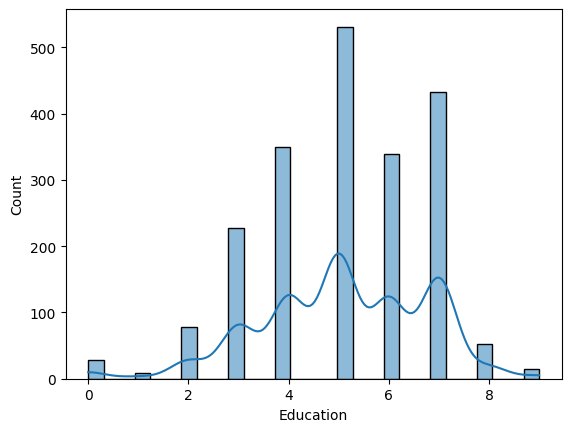

In [113]:
sns.histplot(data=train_df, x='Education', kde=True)

<Axes: >

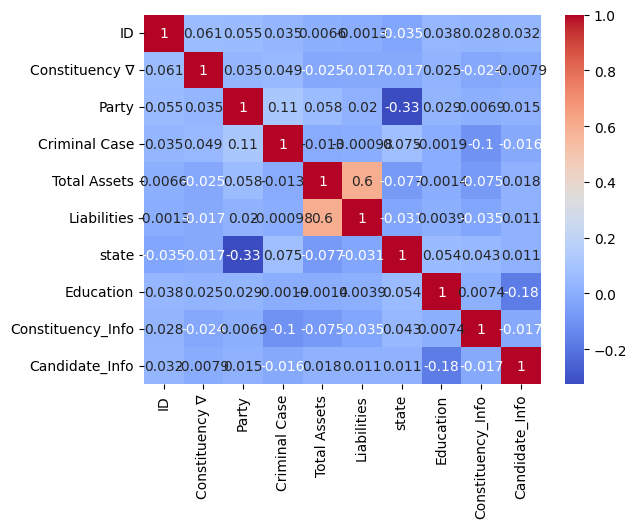

In [114]:

# Remove "Candidate" and "ID" columns
correlation_df = train_df.drop(['Candidate'], axis=1)

# Plot correlation matrix
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm')

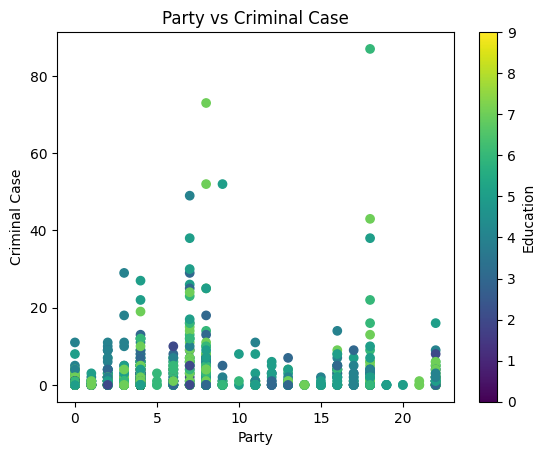

In [115]:

plt.scatter(train3_df['Party'], train3_df['Criminal Case'], c=train3_df['Education'])
plt.xlabel('Party')
plt.ylabel('Criminal Case')
plt.title('Party vs Criminal Case')
plt.colorbar(label='Education')
plt.show()



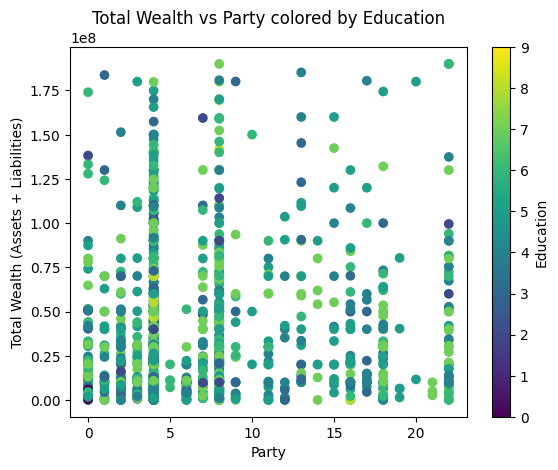

In [116]:

plt.scatter(train3_df['Party'], train3_df['Total Assets'] + train3_df['Liabilities'], c=train3_df['Education'])
plt.xlabel('Party')
plt.ylabel('Total Wealth (Assets + Liabilities)')
plt.title('Total Wealth vs Party colored by Education')
plt.colorbar(label='Education')
plt.show()


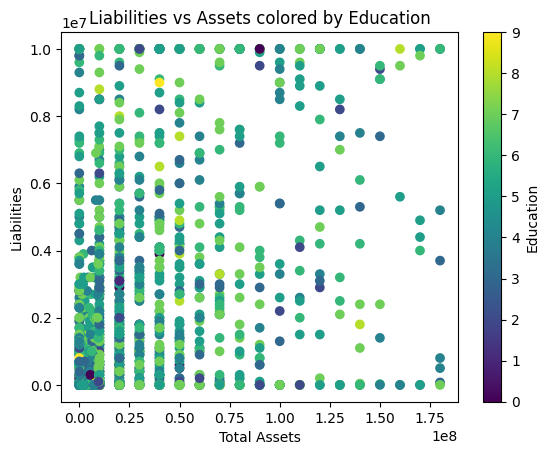

In [117]:

plt.scatter(train3_df['Total Assets'], train3_df['Liabilities'], c=train3_df['Education'])
plt.xlabel('Total Assets')
plt.ylabel('Liabilities')
plt.title('Liabilities vs Assets colored by Education')
plt.colorbar(label='Education')
plt.show()
